In [12]:
import json 
with open('padel-data-labels/labels/2022_BCN_FinalF_1_ball.json','r') as f :
    data = f.read()
data =   json.loads(data)

In [13]:
#Print all keys for the json file  
for key in data.keys():
    print(key)

licenses
info
categories
images
annotations


In [43]:
max_image = 19626  
ball_categorie ={}
for category in data['categories']: 
    if(category["name"] == "Ball"):
        ball_categorie = category
images_data = {}
for image in data['images']:
    images_data[image['id']+1] = image 
ball_data = {}
for annotation in data['annotations']:
    if(int(annotation['image_id']) > max_image):
        continue
    if(annotation["category_id"] == ball_categorie["id"] and annotation["image_id"] in images_data):
        ball_data[annotation["id"]] = {
            'image_id' :  images_data[annotation['image_id']]['file_name'],
            'bbox' : annotation['bbox'],
            "area" : annotation['area'],
            "width" : images_data[annotation['image_id']]['width'],
            "height" : images_data[annotation['image_id']]['height']
        }
print(ball_data[len(ball_data)-1])        

{'image_id': 'frame_019622.PNG', 'bbox': [1140.75, 738.39, 12.7, 12.05], 'area': 153.03500000000142, 'width': 1920, 'height': 1080}


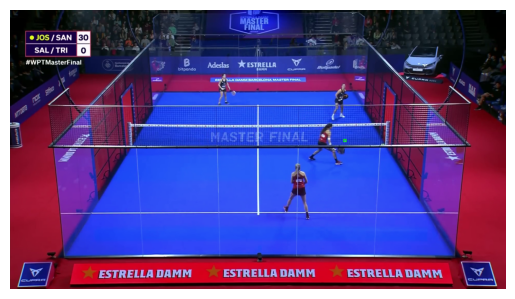

In [44]:
import cv2
import matplotlib.pyplot as plt
import os
img_path = f"frames/frames_finalF/{ball_data[1000]['image_id']}"
if not os.path.exists(img_path):
    raise FileNotFoundError(f"Image not found: {img_path}")
image_bgr = cv2.imread(img_path)
x_min, y_min, w_box, h_box = ball_data[1000]['bbox']
x1 = int(x_min)
y1 = int(y_min)
x2 = int(x_min + w_box)
y2 = int(y_min + h_box)
cv2.rectangle(image_bgr, (x1, y1), (x2, y2), (0, 255, 0), 2)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.axis("off")
plt.show()


In [45]:
images_dir = "frames/frames_finalF"
out_root = "dataset"
os.makedirs(f"{out_root}/images/train", exist_ok=True)
os.makedirs(f"{out_root}/images/val", exist_ok=True)
os.makedirs(f"{out_root}/labels/train", exist_ok=True)
os.makedirs(f"{out_root}/labels/val", exist_ok=True)

In [46]:
splits = {}
all_ids = sorted({int(d) for d in ball_data})
cut = int(0.8 * len(all_ids))
for i, img_id in enumerate(all_ids):
    splits[img_id] = "train" if i < cut else "val"
  

In [47]:
import os
import json
from collections import defaultdict
from PIL import Image
boxes_by_img = defaultdict(list)
for ball_id in ball_data:
    boxes_by_img[ball_id].append(ball_data[ball_id]["bbox"])

In [48]:

def coco_to_yolo(x, y, w, h, W, H):
    x = max(0, min(x, W-1))
    y = max(0, min(y, H-1))
    w = max(0.0, min(w, W - x))
    h = max(0.0, min(h, H - y))
    x_c = (x + w / 2.0) / W
    y_c = (y + h / 2.0) / H
    w_n = w / W
    h_n = h / H
    return x_c, y_c, w_n, h_n


In [57]:

num_written = 0
skipped = 0

for id in ball_data:
    img_id = ball_data[id]["image_id"]
    src_img = os.path.join(images_dir, img_id)
    if not os.path.exists(src_img):
        print(f"[WARN] Missing image: {src_img}")
        continue
    with Image.open(src_img) as im:
        W, H = im.size
    split = splits[id]
    dst_img = os.path.join(out_root, "images", split, img_id)
    dst_lbl = os.path.join(out_root, "labels", split, os.path.splitext(img_id)[0] + ".txt")

    try:
        if os.path.exists(dst_img):
            os.remove(dst_img)
        os.link(src_img, dst_img)
    except OSError:
        with open(src_img, "rb") as s, open(dst_img, "wb") as d:
            d.write(s.read())

    lines = []
    for (x, y, w, h) in boxes_by_img.get(img_id, []):
        if w <= 0 or h <= 0:
            skipped += 1
            continue
        x_c, y_c, w_n, h_n = coco_to_yolo(x, y, w, h, W, H)

        if w_n <= 0 or h_n <= 0:
            skipped += 1
            continue
        lines.append(f"0 {x_c:.6f} {y_c:.6f} {w_n:.6f} {h_n:.6f}")

    with open(dst_lbl, "w") as f:
        f.write("\n".join(lines))

    num_written += 1

print(f"Images prepared: {num_written}, skipped boxes: {skipped}")

[WARN] Missing image: frames/frames_finalF\frame_000000.PNG
Images prepared: 17749, skipped boxes: 0


In [ ]:
from ultralytics import YOLO
import torch, os

# Pick device automatically
device = 0 if torch.cuda.is_available() else "cpu"

# Safer defaults for Windows/Jupyter
workers = 0          # avoid DataLoader multiprocessing issues on Windows
imgsz = 960          # start here; raise to 1280 later if the ball is tiny
batch = 4 if device == "cpu" else 16

# 1) Load base model
model = YOLO("yolov8n.pt")

# 2) Train
model.train(
    data="data.yaml",   # must define train:/val:(/test:)
    epochs=100,
    imgsz=imgsz,
    batch=batch,
    device=device,      # "cpu" or GPU index
    workers=workers,
    project="runs",
    name="ball_yolo",
    seed=42,
)

# 3) Validate on val split
val_metrics = model.val(data="data.yaml", split="val", imgsz=imgsz, device=device, workers=workers)
print("Val mAP50-95:", getattr(val_metrics.box, "map", None))
"""""
# 4) (Optional) Final test split
# test_metrics = model.val(data="data.yaml", split="test", imgsz=imgsz, device=device, workers=workers)
# print("Test mAP50-95:", getattr(test_metrics.box, "map", None))

# 5) Predict on a folder
best_path = "runs/detect/ball_yolo/weights/best.pt"
if os.path.exists(best_path):
    best = YOLO(best_path)
    results = best.predict(
        source="dataset/images/val",  # or a single image/video
        imgsz=imgsz,
        conf=0.25,
        iou=0.7,
        device=device,
        save=True,    # saves annotated outputs under runs/predict
    )
    # peek at first few results
    for r in results[:3]:
        print(r.path, getattr(r.boxes, "xyxy", None).shape if hasattr(r, "boxes") else None)

# 6) (Optional) Resume later:
# last = YOLO("runs/detect/ball_yolo/weights/last.pt")
# last.train(resume=True)

# 7) (Optional) Export for deployment:
# best.export(format="onnx")
"""

Ultralytics 8.3.185  Python-3.11.5 torch-2.8.0+cpu CPU (12th Gen Intel Core(TM) i7-12700H)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=960, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=ball_yolo, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, p

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                


  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  8                  -1  1    460288  ultralytics.nn.modules.block.C2f             [256, 256, 1, True]           
  9                  -1  1    164608  ultralytics.nn.modules.block.SPPF            [256, 256, 5]                 
 10                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None

train: Scanning C:\Users\YounèsAITKETTOUT\Desktop\ProjetPerso\padel_referee_automate-\dataset\labels\train... 2929 images, 2929 backgrounds, 0 corrupt:  21%|██        | 2929/14198 [00:27<02:24, 77.78it/s] 